# Predicting Flight Delays

We have a large data set (7 million points) of flight arrivals in 2008. Can we predict how much a flight will be delayed before it takes off? Let's take a look.

Note that this notebook has been run partially with a fraction (0.01) of the data set and partially with a larger percentage to get the final results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline
sns.set_style('white')

Using large fractions ( > 0.3 ) of the data set kills my kernal, so I've done what I can with a smaller fraction.

In [2]:
raw_data = pd.read_csv('2008.csv').sample(frac=.3)
len(raw_data)

2102918

In [3]:
data_clean = raw_data.reset_index(drop=True)
data_clean.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,4,30,3,844.0,845,1021.0,1017,F9,403,...,12.0,12.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,5,6,1348.0,1355,1548.0,1555,DL,24,...,11.0,15.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,2,26,2,2039.0,2010,19.0,2325,B6,459,...,4.0,16.0,0,NaN,0,0.0,0.0,25.0,0.0,29.0
3,2008,5,15,4,850.0,853,1025.0,1015,NW,238,...,8.0,22.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,4,14,1,949.0,955,1105.0,1104,NW,627,...,19.0,13.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


First of all, I'm going to convert Year, Month, and DayofMonth to DayOfYear. This should capture holidays better than the features separately.

In [4]:
data_clean['DayOfYear'] = [datetime.datetime(
    data_clean.loc[row, 'Year'], 
    data_clean.loc[row, 'Month'], 
    data_clean.loc[row, 'DayofMonth']).timetuple().tm_yday for row in range(len(raw_data))]

In [5]:
data_clean['DayOfYear'].head()

0    121
1      5
2     57
3    136
4    105
Name: DayOfYear, dtype: int64

In [6]:
data_clean.drop(['Year', 'Month', 'DayofMonth'], axis=1, inplace=True)
data_clean.head()

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,...,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DayOfYear
0,3,844.0,845,1021.0,1017,F9,403,N947FR,157.0,152.0,...,12.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,121
1,6,1348.0,1355,1548.0,1555,DL,24,N979DL,120.0,120.0,...,15.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,5
2,2,2039.0,2010,19.0,2325,B6,459,N589JB,220.0,195.0,...,16.0,0,NaN,0,0.0,0.0,25.0,0.0,29.0,57
3,4,850.0,853,1025.0,1015,NW,238,N333NW,95.0,82.0,...,22.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,136
4,1,949.0,955,1105.0,1104,NW,627,N332NB,76.0,69.0,...,13.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,105


In [7]:
data_clean.columns

Index(['DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest',
       'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode',
       'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'DayOfYear'],
      dtype='object')

What are we actually trying to predict with this data set? 

**Will a flight be at least 30 minutes late?**

The variable for this is "ArrDelay", and we'll have to convert it to binary.

Great, but that also means there's a lot of data in there that we can't actually use. Specifically, CarrierDelay through LateAircraftDelay are all a breakdown of WHY we're late. They contain the output variable, and can't be used predictively. Same with ArrTime, AirTime, TaxiIn, and ActualElapsedTime. Cancelled, Diverted, and TaxiOut are sketchy because they aren't known ahead of time. Similarly, DepDelay and DepTime are only known once the flight takes off. If our goal is to predict BEFORE a flight leaves the ground, then these are out as well. Let's see what we're left with.

In [8]:
data_clean.drop(['ArrTime', 'ActualElapsedTime', 'AirTime', 
                 'DepDelay', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 
                 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
                 'LateAircraftDelay'], axis=1, inplace=True)

**NOTE: After running the whole analysis without "DEPTIME" multiple times, it showed that our fit was going to be terrible. I've included that variable in the latest run through the notebook, which substantially improves our results, as it should. Now we're predicting lateness of the flight immediately AFTER takeoff.**

In [9]:
data_clean.columns

Index(['DayOfWeek', 'DepTime', 'CRSDepTime', 'CRSArrTime', 'UniqueCarrier',
       'FlightNum', 'TailNum', 'CRSElapsedTime', 'ArrDelay', 'Origin', 'Dest',
       'Distance', 'DayOfYear'],
      dtype='object')

We should be able to safely dropna() now that most of the offending columns are gone.

In [10]:
data_clean.dropna(inplace=True)
data_clean.describe()

,DayOfWeek,DepTime,CRSDepTime,CRSArrTime,FlightNum,CRSElapsedTime,ArrDelay,Distance,DayOfYear
count,2.056499e+06,2.056499e+06,2.056499e+06,2.056499e+06,2.056499e+06,2.056499e+06,2.056499e+06,2.056499e+06,2.056499e+06
mean,3.926540e+00,1.333566e+03,1.324961e+03,1.493532e+03,2.211488e+03,1.290515e+02,8.144056e+00,7.284976e+02,1.797412e+02
std,1.989331e+00,4.781868e+02,4.643845e+02,4.827513e+02,1.955954e+03,6.950122e+01,3.844851e+01,5.628880e+02,1.040277e+02
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,-1.410000e+02,-1.290000e+02,1.100000e+01,1.000000e+00
25%,2.000000e+00,9.280000e+02,9.250000e+02,1.115000e+03,6.180000e+02,8.000000e+01,-1.000000e+01,3.260000e+02,9.100000e+01
50%,4.000000e+00,1.325000e+03,1.317000e+03,1.515000e+03,1.562000e+03,1.110000e+02,-2.000000e+00,5.810000e+02,1.780000e+02
75%,6.000000e+00,1.728000e+03,1.715000e+03,1.905000e+03,3.492000e+03,1.590000e+02,1.200000e+01,9.540000e+02,2.680000e+02
max,7.000000e+00,2.400000e+03,2.359000e+03,2.359000e+03,9.741000e+03,6.600000e+02,1.417000e+03,4.962000e+03,3.660000e+02


In [11]:
data_clean.shape

(2056499, 13)

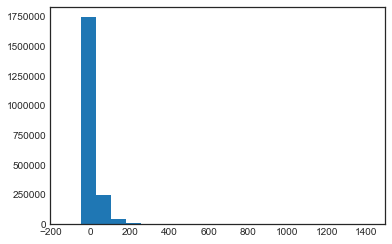

In [12]:
plt.hist(data_clean.ArrDelay, bins=20)
plt.show()

In [13]:
data_clean.ArrDelay.describe()

count    2.056499e+06
mean     8.144056e+00
std      3.844851e+01
min     -1.290000e+02
25%     -1.000000e+01
50%     -2.000000e+00
75%      1.200000e+01
max      1.417000e+03
Name: ArrDelay, dtype: float64

In [14]:
data_clean['IsLate'] = np.where(data_clean.ArrDelay>=30, 1, 0)
data_clean.IsLate.sum(), len(data_clean)
data_clean.columns

Index(['DayOfWeek', 'DepTime', 'CRSDepTime', 'CRSArrTime', 'UniqueCarrier',
       'FlightNum', 'TailNum', 'CRSElapsedTime', 'ArrDelay', 'Origin', 'Dest',
       'Distance', 'DayOfYear', 'IsLate'],
      dtype='object')

We'll be dealing with imbalanced classes here -- only about 13% of flights are delayed at least 30 minutes.

FlightNum and TailNum are categorical variables, so let's remove them for now. We're not going to make dummies for every single plane (although it might be interesting if we had the processing power).

In [15]:
data_clean.drop(['FlightNum', 'TailNum'], axis=1, inplace=True)

In [16]:
data_clean.UniqueCarrier.unique()

array(['F9', 'DL', 'B6', 'NW', 'XE', 'UA', 'AS', 'WN', 'MQ', 'OO', 'YV',
       'FL', 'AA', 'CO', 'EV', 'OH', 'US', '9E', 'HA', 'AQ'], dtype=object)

This one we can make dummies for. Also Origin and Dest (although this will give us a lot of features!). We'll be sure to run feature selection before we run our models.

In [17]:
data_clean = pd.get_dummies(data_clean)

In [18]:
from sklearn.utils import resample

In [19]:
# Data is already shuffled. Create Test Set and a Resampled Training Set.
# Because we're bumping up against processor capacity, we'll downsample the common class
# rather than upsampling the uncommon as we normally would. This preserves more unique data.

test_frac = 0.2
test_size = int(test_frac*len(data_clean))

data_test = data_clean[:test_size]

data_train = data_clean[test_size:]
train_pos = data_train[data_train.IsLate==1]
train_neg = data_train[data_train.IsLate==0]
train_neg = resample(train_neg, n_samples=len(train_pos))
data_train = pd.concat([train_neg, train_pos]).sample(frac=1)

data_train.shape, data_test.shape

((444304, 634), (411299, 634))

In [20]:
X_train = data_train.loc[:, ~data_train.columns.isin(['ArrDelay', 'IsLate'])]
Y_train = data_train['IsLate']

X_test = data_test.loc[:, ~data_test.columns.isin(['ArrDelay', 'IsLate'])]
Y_test = data_test['IsLate']

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, RFE

In [22]:
def auprc(Y, Y_pred):
    precision, recall, thresholds = precision_recall_curve(Y, Y_pred)
    return auc(precision, recall)

Let's start by trying all the models, and then move on to feature selection and gridsearches, etc.

In [31]:
lgr = LogisticRegression(penalty='l2')
lgr.fit(X_train,Y_train)
print(lgr.score(X_test,Y_test))
Y_pred = lgr.predict(X_test)
confusion_matrix(Y_test, Y_pred)

0.795887614233


array([[14350,  3441],
       [  758,  2023]])

In [32]:
las = LogisticRegression(penalty='l1')
las.fit(X_train,Y_train)
print(las.score(X_test,Y_test))
Y_pred = las.predict(X_test)
confusion_matrix(Y_test, Y_pred)

0.784853198522


array([[14184,  3607],
       [  819,  1962]])

In [33]:
knc = KNeighborsClassifier(n_neighbors=4)
knc.fit(X_train,Y_train)
print(knc.score(X_test,Y_test))
Y_pred = knc.predict(X_test)
confusion_matrix(Y_test, Y_pred)

0.879593622399


array([[16277,  1514],
       [  963,  1818]])

In [34]:
dtc = DecisionTreeClassifier(max_depth=20, max_features='sqrt')
dtc.fit(X_train,Y_train)
print(dtc.score(X_test,Y_test))
Y_pred = dtc.predict(X_test)
confusion_matrix(Y_test, Y_pred)

0.568977250632


array([[9967, 7824],
       [1043, 1738]])

In [30]:
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train,Y_train)
print(rfc.score(X_test,Y_test))
Y_pred = rfc.predict(X_test)
confusion_matrix(Y_test, Y_pred)

0.880468598094


array([[17383,   408],
       [ 2051,   730]])

In [52]:
gbc = GradientBoostingClassifier(n_estimators=100, max_depth=3)
gbc.fit(X_train,Y_train)
print(gbc.score(X_test,Y_test))
Y_pred = gbc.predict(X_test)
confusion_matrix(Y_test, Y_pred)

0.632954976511


array([[18606, 11050],
       [ 1529,  3086]])

In [ ]:
# This one takes a long time -- beware when using a large fraction of the data set!
svc = SVC(C=1)
svc.fit(X_train,Y_train)
print(las.score(X_test,Y_test))
Y_pred = las.predict(X_test)
confusion_matrix(Y_test, Y_pred)

These classifiers are working okay -- KNeighbors actually seems to be working best, however we're still only predicting 2/3 of the late arrivals while misclassifying 3x as many negative examples as we are getting right.

Try other feature selection: Random Forest, RFE
Gridsearch RFC and GBC and DTC
Cross Val for models
Try model with DepTime

## Feature Selection

Now with some feature selection. We'll try PCA, SelectKBest, RFE, and Random Forest importances on a couple models to see how they compare.

In [49]:
pca = PCA(n_components=50)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [23]:
skb = SelectKBest(k=50)
skb.fit(X_train, Y_train)
X_train_skb = skb.transform(X_train)
X_test_skb = skb.transform(X_test)

/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [164 330 331 541 593] are constant.
  UserWarning)
/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [44]:
rfe = RFE(estimator=dtc, n_features_to_select=50)
rfe.fit(X_train, Y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

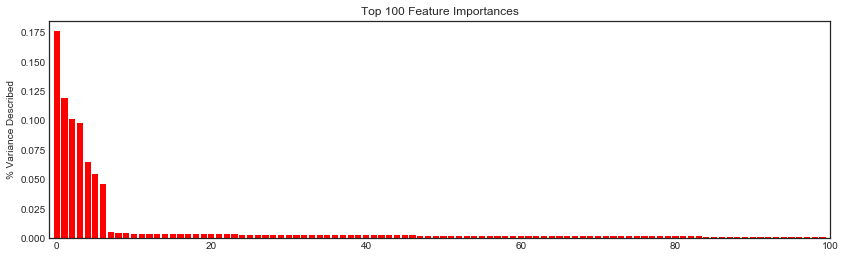

In [35]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
top_indices = indices[:100]

# Plot the feature importances of the forest
plt.figure(figsize=(14, 4))
plt.title("Top {} Feature Importances".format(len(top_indices)))
plt.bar(range(len(top_indices)), importances[top_indices],
       color="r", align="center")
plt.xlim([-1, len(top_indices)])
plt.ylabel('% Variance Described')
plt.show()

In [36]:
for n_idx in [5, 10, 20, 50, 100, 200, 500]:
    print('Variance explained with {} features: {}'.format(n_idx, importances[indices[:n_idx]].sum()))
print('Total Features: ' + str(len(indices)))

Variance explained with 5 features: 0.5587145054985474
Variance explained with 10 features: 0.6727736118156504
Variance explained with 20 features: 0.7100649050963206
Variance explained with 50 features: 0.7923335219020688
Variance explained with 100 features: 0.878118146701283
Variance explained with 200 features: 0.9531306590623553
Variance explained with 500 features: 0.9986587962249636
Total Features: 619


The first 5 features explain a large amount of the variance in the data set, however the long tail of features (Orig, Dest, and Carrier code) is not negligible. We really should include 200 features to get a full picture of the data set.

In [37]:
n_indices = 50
X_train_50 = X_train.loc[:, X_train.columns[indices[:n_indices]]]
X_test_50 = X_test.loc[:, X_train.columns[indices[:n_indices]]]
print(X_train_50.shape, X_test_50.shape)

n_indices = 200
X_train_200 = X_train.loc[:, X_train.columns[indices[:n_indices]]]
X_test_200 = X_test.loc[:, X_train.columns[indices[:n_indices]]]
print(X_train_200.shape, X_test_200.shape)

(82714, 50) (20572, 50)
(82714, 200) (20572, 200)


To recap, our new feature-selected training sets are: X_train_pca, X_train_skb, X_train_rfe, X_train_50, and X_train_200. Let's see how the compare to each other on a simple linear model.

In [50]:
lgr.fit(X_train,Y_train)
print('Full feature set:')
print(lgr.score(X_test,Y_test))
Y_pred = lgr.predict(X_test)
print(confusion_matrix(Y_test, Y_pred))

lgr.fit(X_train_pca,Y_train)
print('PCA w/50 components:')
print(lgr.score(X_test_pca,Y_test))
Y_pred = lgr.predict(X_test_pca)
print(confusion_matrix(Y_test, Y_pred))

lgr.fit(X_train_skb,Y_train)
print('Select K Best w/50 features:')
print(lgr.score(X_test_skb,Y_test))
Y_pred = lgr.predict(X_test_skb)
print(confusion_matrix(Y_test, Y_pred))

lgr.fit(X_train_rfe,Y_train)
print('RFE w/50 features:')
print(lgr.score(X_test_rfe,Y_test))
Y_pred = lgr.predict(X_test_rfe)
print(confusion_matrix(Y_test, Y_pred))

lgr.fit(X_train_50,Y_train)
print('Random Forest w/50 features:')
print(lgr.score(X_test_50,Y_test))
Y_pred = lgr.predict(X_test_50)
print(confusion_matrix(Y_test, Y_pred))

lgr.fit(X_train_200,Y_train)
print('Random Forest w/200 features:')
print(lgr.score(X_test_200,Y_test))
Y_pred = lgr.predict(X_test_200)
print(confusion_matrix(Y_test, Y_pred))

Full feature set:
0.626277372263
[[11173  6634]
 [ 1046  1697]]
PCA w/50 components:
0.615717761557
[[10921  6886]
 [ 1011  1732]]
Select K Best w/50 features:
0.620291970803
[[11005  6802]
 [ 1001  1742]]
RFE w/50 features:
0.619367396594
[[10980  6827]
 [  995  1748]]
Random Forest w/50 features:
0.616739659367
[[10948  6859]
 [ 1017  1726]]
Random Forest w/200 features:
0.624379562044
[[11129  6678]
 [ 1041  1702]]


If we've only got computational power to run with 50 features, SKB is our top choice. Running RFC with 200 features, on the otherhand, gets us within 0.002 accuracy of the full model. Let's use the smaller feature set to find our gridsearch parameters, then run it once on the full set to get the best possible result.

## Grid Search for best results

In [66]:
dtc_params = {'max_depth':[8, 32, 64],
              'max_features':[10, 'sqrt', None],
              'min_samples_split':[2, 8]}
dtc_grid = GridSearchCV(DecisionTreeClassifier(), param_grid=dtc_params, scoring='average_precision')
dtc_grid.fit(X_train_skb, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [8, 32, 64], 'max_features': [10, 'sqrt', None], 'min_samples_split': [2, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='average_precision', verbose=0)

In [67]:
print(dtc_grid.best_score_)
print(dtc_grid.best_params_)

0.853980847258
{'max_depth': 64, 'max_features': 'sqrt', 'min_samples_split': 2}


In [70]:
dtc = DecisionTreeClassifier(max_depth=64, max_features='sqrt', min_samples_split=2)
dtc.fit(X_train, Y_train)
Y_pred = dtc.predict(X_test)
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

[[14514  3293]
 [ 1936   807]]
0.152117090989


In [55]:
rfc_params = {'max_depth':[32, 64, None],
              'n_estimators':[64, 128],
              'min_samples_split':[2, 8, 32]}
rfc_grid = GridSearchCV(RandomForestClassifier(), param_grid=rfc_params)
rfc_grid.fit(X_train_skb, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [32, 64, None], 'n_estimators': [64, 128], 'min_samples_split': [2, 8, 32]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [56]:
print(rfc_grid.best_score_)
print(rfc_grid.best_params_)

0.963276089828
{'max_depth': 64, 'min_samples_split': 2, 'n_estimators': 128}


Sadly, our model is maximizing its accuracy by making fewer predictions and taking advantage of the class imbalance. We might need to use AUPRC instead of 'score'. 

In [ ]:
gbc_params = {'max_depth':[8, 32],
              'n_estimators':[50, 100],
              'learning_rate':[0.1, 0.3]}
gbc_grid = GridSearchCV(GradientBoostingClassifier(), param_grid=gbc_params, scoring='average_precision')
gbc_grid.fit(X_train_skb, Y_train)

In [ ]:
print(gbc_grid.best_score_)
print(gbc_grid.best_params_)

Here's our best model, run with all the data:

In [23]:
rfc = RandomForestClassifier(max_depth=64, min_samples_split=2, n_estimators=128)
rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

[[293198  62341]
 [  9990  45770]]
0.371800394722


In [24]:
print(auprc(Y_test, Y_pred))

0.498674219808


In [25]:
rfc.score(X_test, Y_test)

0.82414010245587754

## Conclusion

We've predicted whether a flight will be late with some accuracy (AUPRC = 0.50, average precision = 0.37), but not as much as I would have hoped for. Additionally, we did really badly (average precision < 0.15) before we added the actual departure time back into the model. I would argue that using this feature is "cheating" and takes away most of the value of our model. Now we're stuck predicting arrival time only once the flight has taken off -- a substantally less robust solution. Additionally, before framing this as a classification problem, I tried it as regression and failed miserably.

Although we have a large number of examples in our data set, we only have one year of data. This means we may be highly sensitive to specific weather patterns, airport construction, and other one-time events that may have skewed the data in some way.

It may be that we did poorly on prediction because there is not much prediction that can be done. Afterall, airline delays are often caused by mechanical delays, staffing issues, and other variables that were not captured in the data set. After removing all the variables that aren't known until the flight is in the air or actually lands, all we're left with is a barebones schedule -- a schedule that airlines have specifically designed to be able to stick to without delays.

An interesting direction to go from here may not be true prediction of delay, but rather deeper examination of how our features affect delays. Which airports have the most delays? What time of day or year is the worst to fly? There is a lot of interesting information to be drawn from this data set, but pure prediction may not be it.